In [167]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.set_printoptions(threshold=10000,suppress=True) 
filterwarnings('ignore')

CREDIT_SCORE = "../data/credit_scoring.csv"

# I) Apprentissage supervisé : Feature engineering et Classification

## **1) Chargement des données et préparation :**

In [216]:
from sklearn.model_selection import train_test_split


# chargement des données
df_credit = pd.read_csv(CREDIT_SCORE, sep=";")
np_credit = df_credit.values

# séparation entre donnée "input": X et les labels: Y
X, Y = np_credit[:, :-1], np_credit[:, -1]

# séparation des données en test et train
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.5, random_state=1)

# exploration des données
txt = f"""Le jeu de donnée présente:
    {X.shape[0]:<6d} enregistrements
    {X.shape[1]:<6d} variables explicatives
    {1:<6d} variable label/classification

Concernant la classification, elle est binaire (0 ou 1) avec:
    {int(Y.sum()):<6d} classe 1 = solvable
    {int(len(Y) - Y.sum()):<6d} classe 0 = non solvable 
"""
print(txt)

display(df_credit.head())

Le jeu de donnée présente:
    4375   enregistrements
    13     variables explicatives
    1      variable label/classification

Concernant la classification, elle est binaire (0 ou 1) avec:
    3159   classe 1 = solvable
    1216   classe 0 = non solvable 



,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price,Status
0,9.0,1.0,60.0,30.0,0.0,1.0,1.0,73.0,129.0,0.0,0.0,800.0,846.0,1
1,17.0,1.0,60.0,58.0,1.0,1.0,0.0,48.0,131.0,0.0,0.0,1000.0,1658.0,1
2,10.0,0.0,36.0,46.0,0.0,2.0,1.0,90.0,200.0,3000.0,0.0,2000.0,2985.0,0
3,0.0,1.0,60.0,24.0,1.0,1.0,0.0,63.0,182.0,2500.0,0.0,900.0,1325.0,1
4,0.0,1.0,36.0,26.0,1.0,1.0,0.0,46.0,107.0,0.0,0.0,310.0,910.0,1


## **2) Apprentissage et évaluation de modèles :**

In [169]:
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                             recall_score)

COLS_EVAL = ["method", "comment", "precision", "accuracy", "recall", "VP", "VN", "FP", "FN", "args"]

def test_model(X_train, Y_train, X_test, Y_test, sk_fun, comment="", **kwargs):
    
    model = sk_fun(**kwargs)      # call a model
    model.fit(X_train, Y_train)     # training
    Y_pred = model.predict(X_test)    # testing
    
    # metrics
    pr, acc, rec = precision_score(Y_test, Y_pred), accuracy_score(Y_test, Y_pred), recall_score(Y_test, Y_pred)
    Conf = confusion_matrix(Y_test, Y_pred)

    # maj df_eval
    line = [sk_fun.__name__, comment, pr, acc, rec, Conf[1, 1], Conf[0, 0], Conf[0, 1], Conf[1, 0], [str(kwargs)]]
    line_df = pd.DataFrame({k:v for k, v in zip(COLS_EVAL, line)}, columns=COLS_EVAL)

    # display confusion matrix
    print(f"Confusion matrix with {sk_fun.__name__} {comment} {str(kwargs)}")
    display(pd.DataFrame(Conf, index=["is 0", "is 1"], columns=["predicted 0", "predicted 1"]))
    
    return line_df

comparative_df = pd.DataFrame(columns=COLS_EVAL)

In [170]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

datas=(xtrain, ytrain, xtest, ytest)

# CART test
cart_test = test_model(*datas, DecisionTreeClassifier, random_state=1)

# KNN test
knn_test = test_model(*datas, KNeighborsClassifier, n_neighbors=5)

# MLP test
mlp_test = test_model(*datas, MLPClassifier, hidden_layer_sizes=(40, 20), random_state=1)

comparative_df = pd.concat([comparative_df, cart_test, knn_test, mlp_test], ignore_index=True)
#drop duplicate line (if multiple evaluations this cells)
comparative_df = comparative_df.drop_duplicates()

Confusion matrix with DecisionTreeClassifier  {'random_state': 1}


,predicted 0,predicted 1
is 0,325,279
is 1,318,1266


Confusion matrix with KNeighborsClassifier  {'n_neighbors': 5}


,predicted 0,predicted 1
is 0,189,415
is 1,187,1397


Confusion matrix with MLPClassifier  {'hidden_layer_sizes': (40, 20), 'random_state': 1}


,predicted 0,predicted 1
is 0,361,243
is 1,482,1102


In [171]:
display(comparative_df.sort_values("precision", ascending=False))

,method,comment,precision,accuracy,recall,VP,VN,FP,FN,args
0,DecisionTreeClassifier,,0.819417,0.727148,0.799242,1266,325,279,318,{'random_state': 1}
2,MLPClassifier,,0.819331,0.668647,0.695707,1102,361,243,482,"{'hidden_layer_sizes': (40, 20), 'random_state..."
1,KNeighborsClassifier,,0.770971,0.724863,0.881944,1397,189,415,187,{'n_neighbors': 5}


On définit la **precision** (ou **positive predictive value**): $\frac{VP}{VP+FP}$ "Parmis les prédictions positives, lesquelles sont justes".

On définit l'**accuracy** : $\frac{VP+FN}{VP+FP+VN+FN}$ "Parmis l'ensemble des prédictions, lesquelles sont justes".

On définit le **recall** (ou **sensibilité** ou **true positive rate**): $\frac{VP}{VP+FN}$ "Parmis les cas postifs, lesquelles sont correctements détectés"

Dans notre situation, nous représentons l'assureur, nous voulons éviter les impayés ! il faut alors minimiser au possible les **faux positifs** (c'est à dire ne pas attribuer un prêt alors qu'un agent ne l'aurait pas fait). 
Ainsi le critère de **précision** est plus important que le recall puisque son calcul prend en compte les faux positifs (la précision augment à mesure que les FP diminue).

## 3) Normalisation des variables continues :

In [172]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Standard scaling datas
stdScale=StandardScaler()
stdScale.fit(xtrain)
xtrain_ss, xtest_ss = stdScale.transform(xtrain), stdScale.transform(xtest)

# Min max scaling datas
mmScale= MinMaxScaler()
mmScale.fit(xtrain)
xtrain_mm, xtest_mm = mmScale.transform(xtrain), mmScale.transform(xtest)

In [173]:
datas_ss = (xtrain_ss, ytrain, xtest_ss, ytest)
datas_mm = (xtrain_mm, ytrain, xtest_mm, ytest)

# CART test with different data scaling
cart_test_ss = test_model(*datas_ss, DecisionTreeClassifier, random_state=1, comment="StdScale")
cart_test_mm = test_model(*datas_mm, DecisionTreeClassifier, random_state=1, comment="MinMaxScale")

# KNN test with different data scaling
knn_test_ss = test_model(*datas_ss, KNeighborsClassifier, n_neighbors=5, comment="StdScale")
knn_test_mm = test_model(*datas_mm, KNeighborsClassifier, n_neighbors=5, comment="MinMaxScale")

# MLP test with different data scaling
mlp_test_ss = test_model(*datas_ss, MLPClassifier, hidden_layer_sizes=(40, 20), random_state=1, comment="StdScale")
mlp_test_mm = test_model(*datas_mm, MLPClassifier, hidden_layer_sizes=(40, 20), random_state=1, comment="MinMaxScale")

comparative_df = pd.concat([comparative_df, cart_test_ss, cart_test_mm, knn_test_ss, knn_test_mm, mlp_test_ss, mlp_test_mm], ignore_index=True)
#drop duplicate line (if multiple evaluations this cells)
comparative_df = comparative_df.drop_duplicates()

Confusion matrix with DecisionTreeClassifier StdScale {'random_state': 1}


,predicted 0,predicted 1
is 0,322,282
is 1,315,1269


Confusion matrix with DecisionTreeClassifier MinMaxScale {'random_state': 1}


,predicted 0,predicted 1
is 0,325,279
is 1,315,1269


Confusion matrix with KNeighborsClassifier StdScale {'n_neighbors': 5}


,predicted 0,predicted 1
is 0,286,318
is 1,223,1361


Confusion matrix with KNeighborsClassifier MinMaxScale {'n_neighbors': 5}


,predicted 0,predicted 1
is 0,283,321
is 1,236,1348


Confusion matrix with MLPClassifier StdScale {'hidden_layer_sizes': (40, 20), 'random_state': 1}


,predicted 0,predicted 1
is 0,342,262
is 1,227,1357


Confusion matrix with MLPClassifier MinMaxScale {'hidden_layer_sizes': (40, 20), 'random_state': 1}


,predicted 0,predicted 1
is 0,321,283
is 1,179,1405


In [174]:
display(comparative_df.sort_values("precision", ascending=False))

,method,comment,precision,accuracy,recall,VP,VN,FP,FN,args
7,MLPClassifier,StdScale,0.838172,0.776508,0.856692,1357,342,262,227,"{'hidden_layer_sizes': (40, 20), 'random_state..."
8,MLPClassifier,MinMaxScale,0.832346,0.788848,0.886995,1405,321,283,179,"{'hidden_layer_sizes': (40, 20), 'random_state..."
4,DecisionTreeClassifier,MinMaxScale,0.819767,0.728519,0.801136,1269,325,279,315,{'random_state': 1}
0,DecisionTreeClassifier,,0.819417,0.727148,0.799242,1266,325,279,318,{'random_state': 1}
2,MLPClassifier,,0.819331,0.668647,0.695707,1102,361,243,482,"{'hidden_layer_sizes': (40, 20), 'random_state..."
3,DecisionTreeClassifier,StdScale,0.818182,0.727148,0.801136,1269,322,282,315,{'random_state': 1}
5,KNeighborsClassifier,StdScale,0.810602,0.752742,0.859217,1361,286,318,223,{'n_neighbors': 5}
6,KNeighborsClassifier,MinMaxScale,0.807669,0.745430,0.851010,1348,283,321,236,{'n_neighbors': 5}
1,KNeighborsClassifier,,0.770971,0.724863,0.881944,1397,189,415,187,{'n_neighbors': 5}


# TEXT A REVOIR

best MLP + stdscale 
a l'excepetion de CART+stdscale, les scale ameliorent les res en precision

## 4) Création de nouvelles variables caractéristiques par combinaisons linéaires des variables initiales 

In [175]:
from sklearn.decomposition import PCA

# PCA computation
pca = PCA()
pca.fit(xtrain_ss)
pca_train, pca_test = pca.transform(xtrain_ss), pca.transform(xtest_ss)

# bind the 3 first PCA axis to std scalled x datas
xtrain_ss_pca = np.column_stack((xtrain_ss, pca_train[:, :3]))
xtest_ss_pca = np.column_stack((xtest_ss, pca_test[:, :3]))

In [176]:
datas_ss_pca = (xtrain_ss_pca, ytrain, xtest_ss_pca, ytest)

# CART test with StdScaling + 3 axis PCA
cart_test_ss_pca = test_model(*datas_ss_pca, DecisionTreeClassifier, random_state=1, comment="StdScale + PCA")

# KNN test with StdScaling + 3 axis PCA
knn_test_ss_pca = test_model(*datas_ss_pca, KNeighborsClassifier, n_neighbors=5, comment="StdScale + PCA")

# MLP test with StdScaling + 3 axis PCA
mlp_test_ss_pca = test_model(*datas_ss_pca, MLPClassifier, hidden_layer_sizes=(40, 20), random_state=1, comment="StdScale + PCA")

comparative_df = pd.concat([comparative_df, cart_test_ss_pca, knn_test_ss_pca, mlp_test_ss_pca], ignore_index=True)
#drop duplicate line (if multiple evaluations above cells)
comparative_df = comparative_df.drop_duplicates()

Confusion matrix with DecisionTreeClassifier StdScale + PCA {'random_state': 1}


,predicted 0,predicted 1
is 0,351,253
is 1,324,1260


Confusion matrix with KNeighborsClassifier StdScale + PCA {'n_neighbors': 5}


,predicted 0,predicted 1
is 0,283,321
is 1,212,1372


Confusion matrix with MLPClassifier StdScale + PCA {'hidden_layer_sizes': (40, 20), 'random_state': 1}


,predicted 0,predicted 1
is 0,318,286
is 1,217,1367


In [177]:
display(comparative_df.sort_values("precision", ascending=False))

,method,comment,precision,accuracy,recall,VP,VN,FP,FN,args
7,MLPClassifier,StdScale,0.838172,0.776508,0.856692,1357,342,262,227,"{'hidden_layer_sizes': (40, 20), 'random_state..."
9,DecisionTreeClassifier,StdScale + PCA,0.832783,0.736289,0.795455,1260,351,253,324,{'random_state': 1}
8,MLPClassifier,MinMaxScale,0.832346,0.788848,0.886995,1405,321,283,179,"{'hidden_layer_sizes': (40, 20), 'random_state..."
11,MLPClassifier,StdScale + PCA,0.826981,0.770110,0.863005,1367,318,286,217,"{'hidden_layer_sizes': (40, 20), 'random_state..."
4,DecisionTreeClassifier,MinMaxScale,0.819767,0.728519,0.801136,1269,325,279,315,{'random_state': 1}
0,DecisionTreeClassifier,,0.819417,0.727148,0.799242,1266,325,279,318,{'random_state': 1}
2,MLPClassifier,,0.819331,0.668647,0.695707,1102,361,243,482,"{'hidden_layer_sizes': (40, 20), 'random_state..."
3,DecisionTreeClassifier,StdScale,0.818182,0.727148,0.801136,1269,322,282,315,{'random_state': 1}
5,KNeighborsClassifier,StdScale,0.810602,0.752742,0.859217,1361,286,318,223,{'n_neighbors': 5}
10,KNeighborsClassifier,StdScale + PCA,0.810396,0.756399,0.866162,1372,283,321,212,{'n_neighbors': 5}


# TEXT A REVOIR

## 5) Sélection de variables

['Income' 'Seniority' 'Price' 'Amount' 'Age' 'Assets' 'Expenses' 'Records'
 'Time' 'Job' 'Debt' 'Home' 'Marital']


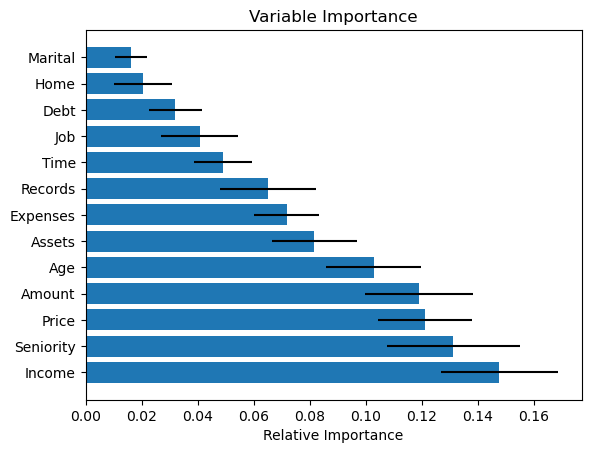

In [178]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state = 1)
clf.fit(xtrain_ss, ytrain)
importances=clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
sorted_idx = np.argsort(importances)[::-1]
features = df_credit.columns.values
print(features[sorted_idx])
padding = np.arange(xtrain_ss.size/len(xtrain_ss)) + 0.5 
plt.barh(padding, importances[sorted_idx],xerr=std[sorted_idx], align='center') 
plt.yticks(padding, features[sorted_idx]) 
plt.xlabel("Relative Importance")
plt.title("Variable Importance") 
plt.show()

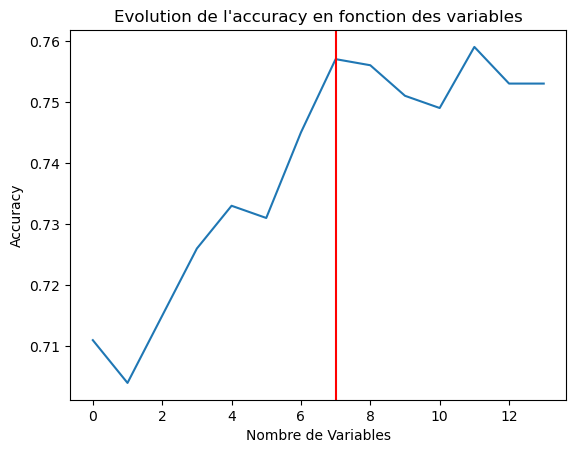

In [179]:
KNN=KNeighborsClassifier(n_neighbors=5)
scores=np.zeros(xtrain_ss.shape[1]+1)
for f in np.arange(0, xtrain_ss.shape[1]+1):
    X1_f = xtrain_ss[:,sorted_idx[:f+1]]
    X2_f = xtest_ss[:,sorted_idx[:f+1]]
    KNN.fit(X1_f,ytrain)
    YKNN=KNN.predict(X2_f)
    scores[f]=np.round(accuracy_score(ytest,YKNN),3)
plt.plot(scores)
plt.xlabel("Nombre de Variables")
plt.ylabel("Accuracy")
plt.title("Evolution de l'accuracy en fonction des variables")
plt.axvline(x=7, color="red")
plt.show()

In [180]:
X_trimmed = np_credit[:, sorted_idx[:8]]

# Y ne change pas, et avec random_state constant, ytrain et ytest non plus
xtrain_trim, xtest_trim, ytrain, ytest = train_test_split(X_trimmed, Y, test_size=0.5, random_state=1)

stdScale=StandardScaler()
stdScale.fit(xtrain_trim)

xtrain_trim_ss = stdScale.transform(xtrain_trim)
xtest_trim_ss = stdScale.transform(xtest_trim)

# TEXT A REVOIR

now on work avec des données moins bruités (trimmed) + normalized stdscale

## 6) Paramétrage des classifieurs :

In [181]:
from sklearn.model_selection import GridSearchCV
from os.path import exists
from pickle import load, dump

def find_best_param(sk_function, params, X_train, Y_train):
    file_name = f"../res/pickle/gs_{sk_function.__name__}.pkl"

    if exists(file_name):
        gs = load(open(file_name, "rb"))

    else:
        gs = GridSearchCV(sk_function(), params, scoring="precision") #we target the best precision score)
        gs.fit(X_train, Y_train)
        dump(gs, open(file_name, "wb"))
    
    print(f"Best params for '{sk_function.__name__}' is :\n{gs.best_params_}\nscore (precision): {gs.best_score_}\n")
    return gs

In [182]:
# KNN test
parameters_knn = {
    "n_neighbors" : [i for i in range(1, 100, 5)],
    "weights" : ["uniform", "distance"],
    "algorithm" : ['auto', 'ball_tree', 'kd_tree', 'brute']
}
gs_knn = find_best_param(KNeighborsClassifier, parameters_knn, xtrain_trim_ss, ytrain)

# CART test
parameters_cart = {
    "criterion" : ["gini", "entropy", "log_loss"],
    "splitter" : ["best", "random"],
    "max_depth" : [i for i in range(1, 16)],
    "min_samples_leaf" : [i for i in range(1, 16)],
    "min_samples_split" : [i for i in range(1, 16)]
}
gs_cart = find_best_param(DecisionTreeClassifier, parameters_cart, xtrain_trim_ss, ytrain)

# MLP test
parameters_mlp = {
    "activation" : ["identity", "logistic", "tanh", "relu"],
    "hidden_layer_sizes" : [(l1, l2) for l1 in range(10, 121, 10) for l2 in range(10, 81, 10)]
}
gs_mlp = find_best_param(MLPClassifier, parameters_mlp, xtrain_trim_ss, ytrain)




Best params for 'KNeighborsClassifier' is :
{'algorithm': 'auto', 'n_neighbors': 6, 'weights': 'uniform'}
score (precision): 0.810517460555068

Best params for 'DecisionTreeClassifier' is :
{'criterion': 'log_loss', 'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'}
score (precision): 0.8228225962131669

Best params for 'MLPClassifier' is :
{'activation': 'relu', 'hidden_layer_sizes': (120, 30)}
score (precision): 0.8263374541428663



# TEXT A REVOIR

blablabla

## 7) Création d'un pipeline :

In [183]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

SIGNIFICANCE_COLS = sorted_idx[:8]
COLS_EVAL_2 = ["method", "accuracy", "precision", "params"]

def make_pipeline(X_train, Y_train, sk_function, params):
    # describe the pipeline
    trim = ColumnTransformer([("trim", "passthrough", SIGNIFICANCE_COLS)]) # trim data with 7 best variables
    # StdScaling data
    trim_ss = Pipeline([
        ("trim", trim), 
        ('stdScale', StandardScaler())
    ])
    # StdScaling data then get 3 first PCA axis 
    trim_ss_pca3 = Pipeline([
        ("trim", trim), 
        ('stdScale', StandardScaler()), 
        ('pca3comp', PCA(n_components=3))
    ])
    # bind 3 frist PCA axis to the scaled data
    prep_data = FeatureUnion([
        ('trim + stdScale', trim_ss),
        ('trim + stdScale + pca3comp', trim_ss_pca3)
    ]) 
    # then add estimator
    pipeline = Pipeline([
        ('preprocess', prep_data), 
        ('model', sk_function(**params))
    ]) 
    
    # train the pipeline
    pipeline.fit(X_train, Y_train)

    # save the pipeline with pickle
    dump(pipeline, open(f"../res/pickle/pipe_{sk_function.__name__}.pkl", "wb"))

    # display the 'html' description of the pipeline
    display(pipeline)


def test_pipeline(pipelines, X_test, Y_test):
    df = pd.DataFrame(columns=COLS_EVAL_2)
    for pipe in pipelines:
        Y_pred = pipe.predict(X_test)
        dict_line = {
            "method" : pipe.named_steps['model'].__class__.__name__,
            "accuracy" : pipe.score(X_test, Y_test),
            "precision" : precision_score(Y_test, Y_pred),
            "params" : [pipe.named_steps['model']]
        }
        df_line = pd.DataFrame(dict_line, columns=COLS_EVAL_2)
        df = pd.concat([df, df_line], ignore_index=True)
    return df

In [184]:
# making pipeline and save it as pickle
make_pipeline(xtrain, ytrain, KNeighborsClassifier, gs_knn.best_params_)
make_pipeline(xtrain, ytrain, DecisionTreeClassifier, gs_cart.best_params_)
make_pipeline(xtrain, ytrain, MLPClassifier, gs_mlp.best_params_)

# load pipeline
pipe_KNN = load(open("../res/pickle/pipe_KNeighborsClassifier.pkl", "rb"))
pipe_CART = load(open("../res/pickle/pipe_DecisionTreeClassifier.pkl", "rb"))
pipe_MLP = load(open("../res/pickle/pipe_MLPClassifier.pkl", "rb"))

# test
test_pipe = test_pipeline([pipe_KNN, pipe_CART, pipe_MLP], xtest, ytest)
display(test_pipe)

# to use a model:
# 1) load it : mymodel = pickle.load("path_of_the_model", "rb")
# 
# 2) use it : Y_prediction = mymodel.predict(X_data)
# X_data is a numpy array !

Pipeline(steps=[('preprocess',
                 FeatureUnion(transformer_list=[('trim + stdScale',
                                                 Pipeline(steps=[('trim',
                                                                  ColumnTransformer(transformers=[('trim',
                                                                                                   'passthrough',
                                                                                                   array([ 8,  0, 12, 11,  3,  9,  7,  5]))])),
                                                                 ('stdScale',
                                                                  StandardScaler())])),
                                                ('trim + stdScale + pca3comp',
                                                 Pipeline(steps=[('trim',
                                                                  ColumnTransformer(transformers=[('trim',
                                                                                                   'passthrough',
                                                                                                   array([ 8,  0, 12, 11,  3,  9,  7,  5]))])),
                                                                 ('stdScale',
                                                                  StandardScaler()),
                                                                 ('pca3comp',
                                                                  PCA(n_components=3))]))])),
                ('model', KNeighborsClassifier(n_neighbors=6))])

Pipeline(steps=[('preprocess',
                 FeatureUnion(transformer_list=[('trim + stdScale',
                                                 Pipeline(steps=[('trim',
                                                                  ColumnTransformer(transformers=[('trim',
                                                                                                   'passthrough',
                                                                                                   array([ 8,  0, 12, 11,  3,  9,  7,  5]))])),
                                                                 ('stdScale',
                                                                  StandardScaler())])),
                                                ('trim + stdScale + pca3comp',
                                                 Pipeline(steps=[('trim',
                                                                  ColumnTransformer(transformers=[('trim',
                                                                                                   'passthrough',
                                                                                                   array([ 8,  0, 12, 11,  3,  9,  7,  5]))])),
                                                                 ('stdScale',
                                                                  StandardScaler()),
                                                                 ('pca3comp',
                                                                  PCA(n_components=3))]))])),
                ('model',
                 DecisionTreeClassifier(criterion='log_loss', max_depth=12,
                                        min_samples_leaf=2,
                                        splitter='random'))])

Pipeline(steps=[('preprocess',
                 FeatureUnion(transformer_list=[('trim + stdScale',
                                                 Pipeline(steps=[('trim',
                                                                  ColumnTransformer(transformers=[('trim',
                                                                                                   'passthrough',
                                                                                                   array([ 8,  0, 12, 11,  3,  9,  7,  5]))])),
                                                                 ('stdScale',
                                                                  StandardScaler())])),
                                                ('trim + stdScale + pca3comp',
                                                 Pipeline(steps=[('trim',
                                                                  ColumnTransformer(transformers=[('trim',
                                                                                                   'passthrough',
                                                                                                   array([ 8,  0, 12, 11,  3,  9,  7,  5]))])),
                                                                 ('stdScale',
                                                                  StandardScaler()),
                                                                 ('pca3comp',
                                                                  PCA(n_components=3))]))])),
                ('model', MLPClassifier(hidden_layer_sizes=(120, 30)))])

,method,accuracy,precision,params
0,KNeighborsClassifier,0.744059,0.832036,KNeighborsClassifier(n_neighbors=6)
1,DecisionTreeClassifier,0.712980,0.795062,"DecisionTreeClassifier(criterion='log_loss', m..."
2,MLPClassifier,0.767824,0.817967,"MLPClassifier(hidden_layer_sizes=(120, 30))"


## 8) Comparaison de plusieurs algorithmes d’apprentissage :

In [237]:
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

CLASSIFIERS = { 
  'RF_20': RandomForestClassifier(n_estimators=20, random_state=1),
  'RF_40': RandomForestClassifier(n_estimators=40, random_state=1),
  'RF_80': RandomForestClassifier(n_estimators=80, random_state=1),
  'RF_120': RandomForestClassifier(n_estimators=120, random_state=1),
  'RF_160': RandomForestClassifier(n_estimators=160, random_state=1),
  'RF_200': RandomForestClassifier(n_estimators=200, random_state=1),

  "NB": GaussianNB(),
  "QDA": QuadraticDiscriminantAnalysis(),

  "MLP_20_10" : MLPClassifier(hidden_layer_sizes=(20,10), random_state=1),
  "MLP_40_20" : MLPClassifier(hidden_layer_sizes=(40,20), random_state=1),
  "MLP_60_30" : MLPClassifier(hidden_layer_sizes=(60,30), random_state=1),
  "MLP_90_45" : MLPClassifier(hidden_layer_sizes=(90,45), random_state=1),
  "MLP_120_60" : MLPClassifier(hidden_layer_sizes=(120,60), random_state=1),

  "CART_gini" : DecisionTreeClassifier(criterion="gini", random_state=1),
  "CART_entropy" : DecisionTreeClassifier(criterion="entropy", random_state=1),
  "CART_log_loss" : DecisionTreeClassifier(criterion="log_loss", random_state=1),
  
  "KNN_20" : KNeighborsClassifier(n_neighbors=20),
  "KNN_40" : KNeighborsClassifier(n_neighbors=40),
  "KNN_80" :  KNeighborsClassifier(n_neighbors=80),
  "KNN_120" :  KNeighborsClassifier(n_neighbors=120),
  "KNN_160" :  KNeighborsClassifier(n_neighbors=160),
  "KNN_200" :  KNeighborsClassifier(n_neighbors=200),

  "Bag_20" : BaggingClassifier(n_estimators=20, random_state=1),
  "Bag_40" : BaggingClassifier(n_estimators=40, random_state=1),
  "Bag_80" : BaggingClassifier(n_estimators=80, random_state=1),
  "Bag_120" : BaggingClassifier(n_estimators=120, random_state=1),
  "Bag_160" : BaggingClassifier(n_estimators=160, random_state=1),
  "Bag_200" : BaggingClassifier(n_estimators=200, random_state=1),

  "AdaB_20" : AdaBoostClassifier(n_estimators=20, random_state=1),
  "AdaB_40" : AdaBoostClassifier(n_estimators=40, random_state=1),
  "AdaB_80" : AdaBoostClassifier(n_estimators=80, random_state=1),
  "AdaB_120" : AdaBoostClassifier(n_estimators=120, random_state=1),
  "AdaB_160" : AdaBoostClassifier(n_estimators=160, random_state=1),
  "AdaB_200" : AdaBoostClassifier(n_estimators=200, random_state=1)
}

In [186]:
from sklearn.model_selection import (cross_validate, KFold)
from sys import stderr

def log_msg(msg):
    print(f"\r{' '*80}", file=stderr, end="")
    print(f"\r{msg}", file=stderr, end="")

COLS_EVAL_3 = ['method', 'test_precision_mean', 'test_precision_sd', 
    'test_accuracy_mean', 'test_accuracy_sd','test_roc_auc_mean', 'test_roc_auc_sd',
    'fit_time_mean', 'fit_time_sd', 'score_time_mean', 'score_time_sd',
]

def run_classifiers(sk_func_dict, X, Y, scores=['accuracy', 'precision', 'roc_auc'], nb_split=10):
    df = pd.DataFrame(columns=COLS_EVAL_3)
    kf = KFold(n_splits=nb_split, shuffle=True, random_state=0)
    size_clfs = len(sk_func_dict)
    for idx, key in enumerate(sk_func_dict):
        log_msg(f"{key} is running! ({idx+1}/{size_clfs})")
        
        cv_metrics = cross_validate(sk_func_dict[key], X, Y, cv=kf, scoring=scores)
        dict_metrics = {i:{'mean':np.mean(v), 'sd':np.std(v)} for i, v in cv_metrics.items()}
        dict_metrics["method"] = key
        df_metrics = pd.json_normalize(dict_metrics, sep="_")
        df = pd.concat([df, df_metrics], ignore_index=True)
    print("")
    return df

In [187]:
if exists("../res/pickle/run1.pkl"):
    run1 = load(open("../res/pickle/run1.pkl", "rb"))
else:
    run1 = run_classifiers(CLASSIFIERS, xtrain_trim_ss, ytrain)
    dump(run1, open("../res/pickle/run1.pkl", "wb"))
    
display(run1.sort_values("test_roc_auc_mean"))

,method,test_precision_mean,test_precision_sd,test_accuracy_mean,test_accuracy_sd,test_roc_auc_mean,test_roc_auc_sd,fit_time_mean,fit_time_sd,score_time_mean,score_time_sd
10,CART_entropy,0.785420,0.034252,0.692723,0.033005,0.616493,0.043290,0.012891,0.002229,0.002532,0.001034
11,CART_log_loss,0.785420,0.034252,0.692723,0.033005,0.616493,0.043290,0.009497,0.000552,0.001386,0.000105
9,CART_gini,0.796934,0.028120,0.700034,0.023687,0.634935,0.028917,0.010827,0.000635,0.002674,0.000597
17,Bag_10,0.815618,0.037590,0.734330,0.031437,0.752610,0.033439,0.056347,0.000928,0.003207,0.000055
0,RF_10,0.804675,0.043219,0.731155,0.034073,0.755873,0.037150,0.027563,0.003196,0.004453,0.001331
5,NB,0.779316,0.037645,0.743513,0.035453,0.768436,0.037450,0.000621,0.000038,0.001375,0.000070
12,KNN_10,0.806272,0.043899,0.744889,0.033597,0.770327,0.031325,0.000868,0.000016,0.012906,0.000127
1,RF_20,0.804183,0.041477,0.748990,0.034449,0.773982,0.034662,0.049191,0.006096,0.005207,0.000680
18,Bag_20,0.810245,0.040316,0.741205,0.029215,0.774000,0.027034,0.111496,0.001020,0.004618,0.000062
19,Bag_40,0.803583,0.038218,0.745321,0.028401,0.779491,0.029983,0.222081,0.001815,0.007619,0.000099


In [188]:
from matplotlib import colormaps

COLOR_CLFS = {
  "RF"    : colormaps["tab10"].colors[0],
  "Bag"   : colormaps["tab10"].colors[1], 
  "AdaB"  : colormaps["tab10"].colors[2],
  "NB"    : colormaps["tab10"].colors[3],
  "MLP"   : colormaps["tab10"].colors[4],
  "CART"  : colormaps["tab10"].colors[4],
  "KNN"   : colormaps["tab10"].colors[6],
  "QDA"   : colormaps["tab10"].colors[7]
}

In [189]:
def result_run_clfs(run_df, run_name, top, vars, color_dict):
    fig, ax = plt.subplots(ncols=len(vars), figsize=(8, 0.3*top))

    for i, var in enumerate(vars): # len(vars) loop
        mean, sd = f"test_{var}_mean", f"test_{var}_sd"
        
        idx = run_df.sort_values(by=mean, ascending=False).index[:top]
        st, ed = run_df[mean][idx].tolist()[-1], run_df[mean][idx].tolist()[0]
        st, ed = st*0.9, ed*1.1
        
        ax[i].set_xlim([st, ed])
        ax[i].tick_params(axis='both', labelsize='xx-small')
        ax[i].set_title(f"Top {top} '{var}'", fontsize='small')

      
        for r in idx[::-1]: # n methods loop
            serie = run_df.iloc[r]
            c = color_dict[serie["method"].split("_")[0]]
            ax[i].barh(serie["method"], serie[mean], xerr=serie[sd], color=c)

    fig.suptitle(f"Top {top} methods for {run_name}", fontsize=16)
    fig.tight_layout()

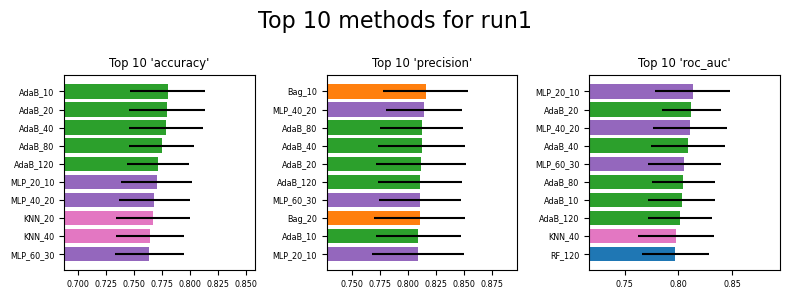

In [190]:
result_run_clfs(run1, "run1", 10, ['accuracy', 'precision', 'roc_auc'], COLOR_CLFS)

# II) Apprentissage supervisé : Données hétérogènes

## Chargement des données et préparation :

In [191]:
CREDIT_SCORE_HET = "../data/credit.data"

df_credit_het = pd.read_csv(CREDIT_SCORE_HET, sep="\t", header=None, na_values="?")
df_credit_het.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,+


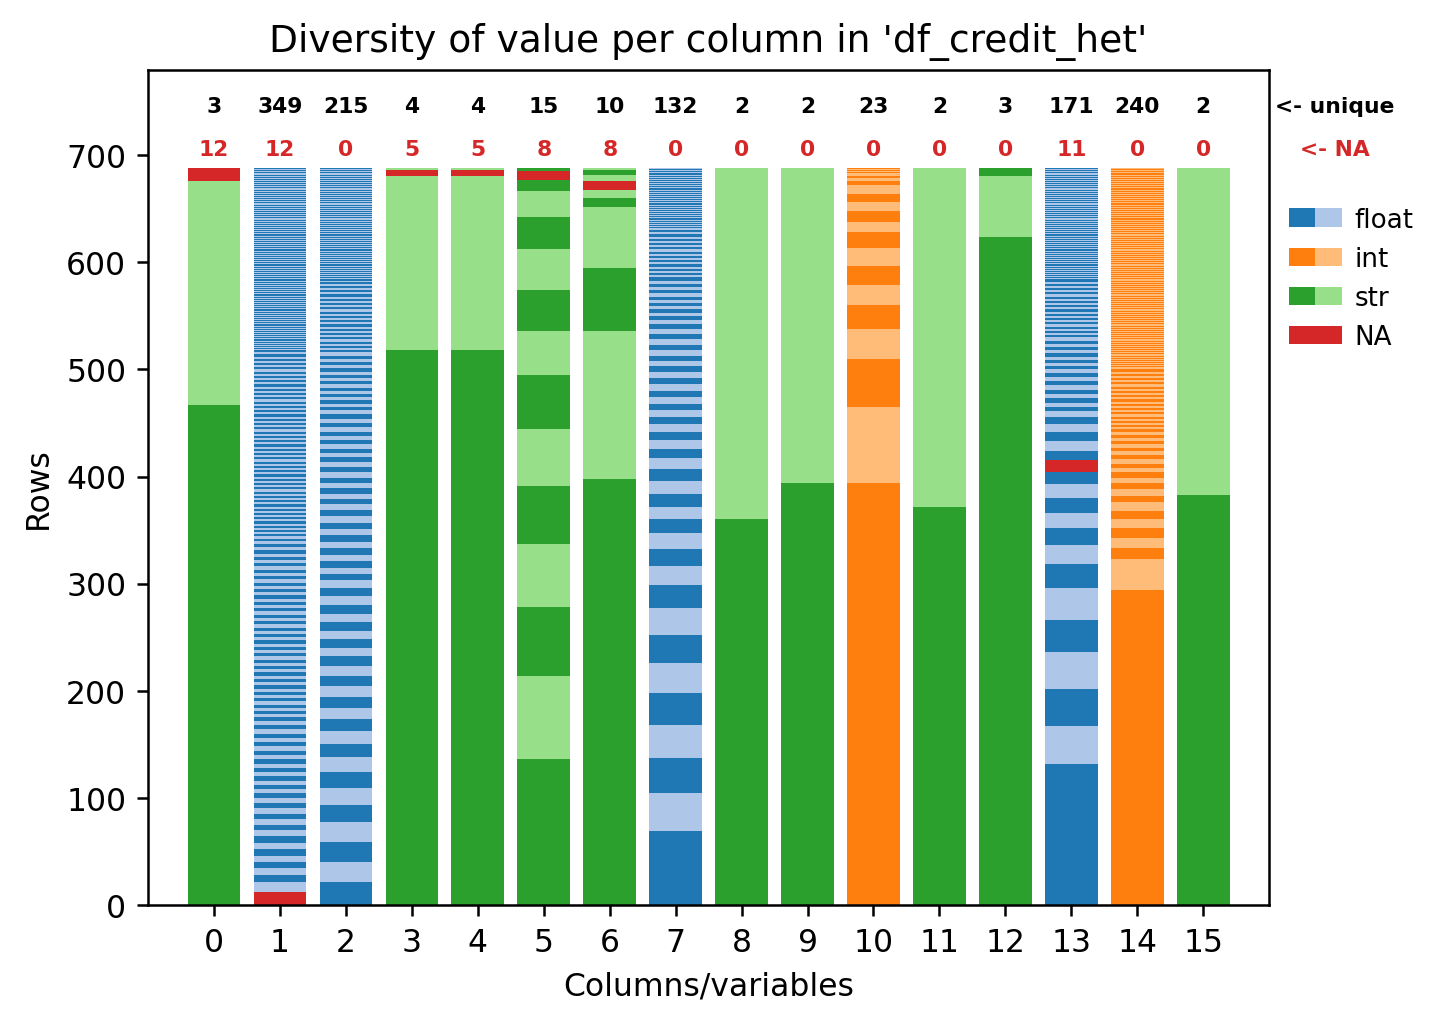

In [192]:
from matplotlib.patches import Patch


COLORS = colormaps['tab20'].colors[:8]

fig, ax = plt.subplots(dpi=226)

ax.set_ylim([0, 780])
ax.set_xlim([-1, 16])

f1, f2 = Patch(facecolor=COLORS[0]), Patch(facecolor=COLORS[1])
i1, i2 = Patch(facecolor=COLORS[2]), Patch(facecolor=COLORS[3])
s1, s2 = Patch(facecolor=COLORS[4]), Patch(facecolor=COLORS[5])
n1 = Patch(facecolor=COLORS[6])

txt_args = {'horizontalalignment':'center', 'fontweight':'bold', 'fontsize':'x-small'}
lgd_args = {
    'columnspacing': -0.5, 'handlelength': 1.0, 'handletextpad': 0.5, 
    'fontsize':'small', 'frameon':False, 'bbox_to_anchor' : (1.15, 0.75)
}

for col in df_credit_het.columns:
    cumul = 0
    serie = df_credit_het[col]
    count = serie.value_counts(dropna=False).sort_values(ascending=False)

    for idx, item in enumerate(count.items()): 
        val, cnt = item
        if pd.isna(val):
            c = COLORS[6]
        elif isinstance(val, float):
            c = COLORS[0] if idx%2 == 0 else COLORS[1]
        elif isinstance(val, int):
            c = COLORS[2] if idx%2 == 0 else COLORS[3]
        elif isinstance(val, str):
            c = COLORS[4] if idx%2 == 0 else COLORS[5]
        else:
            print("err")
    
        ax.bar(x=str(col), height=cnt, bottom=cumul, color=c)
        cumul += cnt        

    ax.text(col, 740, count.shape[0], **txt_args)
    ax.text(col, 700, serie.isna().sum(), color=COLORS[6], **txt_args)

ax.text(17, 740, "<- unique", **txt_args)
ax.text(17, 700, "<- NA", color=COLORS[6], **txt_args)
ax.set_title("Diversity of value per column in 'df_credit_het'")
ax.set_ylabel("Rows")
ax.set_xlabel("Columns/variables")

ax.legend(handles=[f1, i1, s1, n1, f2, i2, s2, n1],
        labels=['', '', '', '', 'float', 'int', 'str', 'NA'], 
        ncol=2, loc="right", **lgd_args)

|**Cols**|0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|**Type**|str|float|float|str|str|str|str|float|str|str|int|str|str|<span style="color:red">float*</span>|int|str|
|**Variable**|cat|continue|continue|cat|cat|cat|cat|continue|binaire|binaire|discrete|binaire|cat|discrete|discrete|binaire|
|**Modalités**|2|-|-|3|3|13|7|-|2|2|-|2|3|-|-|2|
|**NAvalue**|12|12|-|5|5|8|8|0|0|0|0|0|0|11|0|0|

*La colonne 13 possède des valeurs 'NA', ainsi le type retrouver est 'float' alors que ce sont des valeurs entières. 

La taille du jeu de donné fait 688 lignes pour 16 colonnes. Si l'on élimine les valeurs 'NA' il reste 653 lignes.

In [228]:
Y_COL = [15]
QUALITATIVE_COLS = [0, 3, 4, 5, 6, 12]
BOOL_COLS = [8, 9, 11]
CONTINUE_COLS = [1, 2, 7]
DISCRETE_COLS = [10, 13, 14]

NUM_COLS = CONTINUE_COLS + DISCRETE_COLS
CAT_COLS = QUALITATIVE_COLS + BOOL_COLS

# delete 'NA' values
df_credit_het_nona = df_credit_het.dropna()

# to numpy
np_credit_het_nona = df_credit_het_nona.values

# separate into X_num, X_cat and Y arrays
X_num = np_credit_het_nona[:, NUM_COLS]
X_num = X_num.astype(np.float64)

X_cat = np_credit_het_nona[:, CAT_COLS]

Y = np_credit_het_nona[:, Y_COL]
Y[Y == "+"] = 1
Y[Y == "-"] = 0
Y = Y.astype(np.float64)

## 2) Normalisation des variables continues :

Par continues on entend toute valeurs numériques trouvées dans le jeu de donnée.

In [238]:
# Standard scaling X_num
stdScale=StandardScaler()
X_ss = stdScale.fit_transform(X_num)

# Min max scaling X_num
mmScale= MinMaxScaler()
X_mm = mmScale.fit_transform(X_num)

run2_ss = run_classifiers(CLASSIFIERS, X_ss, Y)
run2_mm = run_classifiers(CLASSIFIERS, X_mm, Y)

AdaB_200 is running! (34/34)                                                    

AdaB_200 is running! (34/34)                                                    

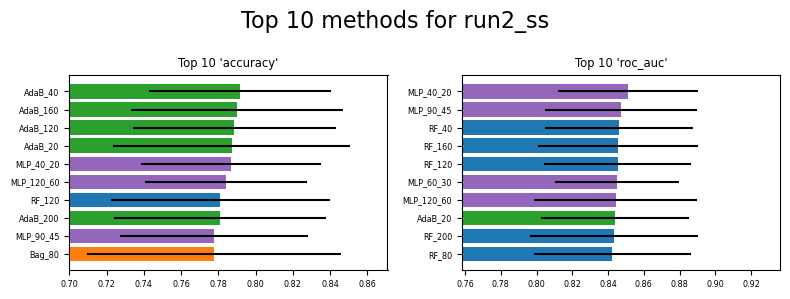

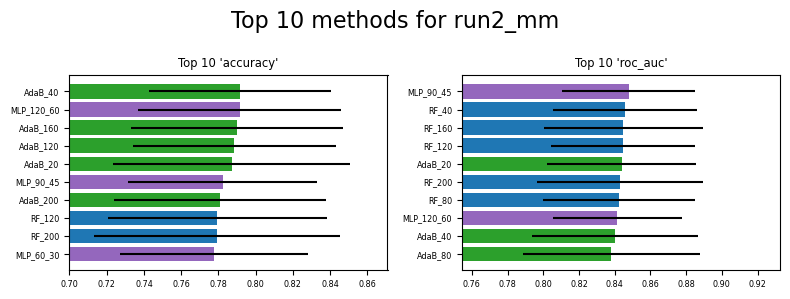

In [241]:
result_run_clfs(run2_ss, "run2_ss", 10, ["accuracy", "roc_auc"], color_dict= COLOR_CLFS)
result_run_clfs(run2_mm, "run2_mm", 10, ["accuracy", "roc_auc"], color_dict= COLOR_CLFS)

## 2) Traitement de données manquantes : 

In [ ]:
# df_credit_het[15] = df_credit_het[15].apply(lambda x: 1 if x == "+" else 0) 
# for i in BOOL_COLS:
#     df_credit_het[i] = df_credit_het[i].apply(lambda x: 1 if x == "t" else 0)
# df_credit_het = df_credit_het.astype(TYPE_COLS)
# df_credit_het.shape
# np_credit_het_str, np_credit_het_num = df_credit_het[STR_COLS].values, df_credit_het[NUM_COLS + BOOL_COLS].values

In [ ]:
txt = f"""Le jeu de donnée présente:
    {X.shape[0]:<6d} enregistrements
    {X.shape[1]:<6d} variables explicatives
    {1:<6d} variable label/classification

Concernant la classification, elle est binaire (0 ou 1) avec:
    {int(Y.sum()):<6d} classe 1 = solvable
    {int(len(Y) - Y.sum()):<6d} classe 0 = non solvable 
"""
print(txt)

Le jeu de donnée présente:
    4375   enregistrements
    13     variables explicatives
    1      variable label/classification

Concernant la classification, elle est binaire (0 ou 1) avec:
    3159   classe 1 = solvable
    1216   classe 0 = non solvable 



ok 
```python
for i in range(10):
    print(i)
```